<p style="font-family: Arials; line-height: 1.3; font-size: 30px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #23527c">Exploring the news dataset</p>


<span style="font-family: Arials; font-size: 20px; font-style: bold; font-weight: bold; letter-spacing: 2px; color: #23527c">1. INTRODUCTION</span>
<hr style="height: 0.5px; border: 0; background-color: 'Black'">

Social media is a vast pool of content, and among all the content available for users to access, news is an element that is accessed most frequently. These news can be posted by politicians, news channels, newspaper websites, or even common civilians. These posts have to be checked for their authenticity, since spreading misinformation has been a real concern in today’s times, and many firms are taking steps to make the common people aware of the consequences of spread misinformation. The measure of authenticity of the news posted online cannot be definitively measured, since the manual classification of news is tedious and time-consuming, and is also subject to bias.

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508152385/Fake_real-1_gebpwg.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


/kaggle/input/source-based-news-classification/news_articles.csv
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


<p style="font-family: Arials; line-height: 1.3; font-size: 27px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #23527c">Reading the dataset</p>

In [2]:
df=pd.read_csv("../input/source-based-news-classification/news_articles.csv")
print(df.shape)
df.head()

(2096, 12)


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [3]:
#Checking for null values
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [4]:
#dropping null values
df.dropna(inplace=True)

---

<p style="font-family: Arials; line-height: 1.3; font-size: 27px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #23527c">Exploratory data analysis</p>

### Let's visualize the proportion of real and fake news!

In [5]:
#real vs fake
fig = px.pie(df,names='label',title='Proportion of Real vs. Fake News')
fig.show()

### Languages of News Articles

In [6]:
sub_tf_df=df.groupby('language').apply(lambda x:x['language'].count()).reset_index(name='Counts')
fig = px.bar(sub_tf_df, x="language", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

As we can see, English is the most common language in which most news articles are written

### Visualizing count of news articles by type

In [7]:
sub_check=df.groupby('type').apply(lambda x:x['type'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='type',y='Counts',color='Counts',title='Count of News Articles by type')
fig.show()

here we can se that most news are of type bs (i.e. bullshit)

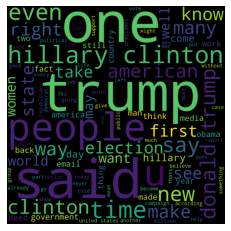

In [8]:
from wordcloud import WordCloud 
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(df['text_without_stopwords']))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Visualizing top 10 unigrams and bigrams

In [9]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [10]:
common_words = get_top_n_words(df['text_without_stopwords'], 10)
df2 = pd.DataFrame(common_words,columns=['word','count'])
df2.groupby('word').sum()['count'].sort_values(ascending=False)
fig=px.bar(df2,x='word',y='count',color='count',title='Top 10 unigrams')
fig.show()

In [11]:
common_words = get_top_n_bigram(df['text_without_stopwords'], 10)
df2 = pd.DataFrame(common_words,columns=['word','count'])
df2.groupby('word').sum()['count'].sort_values(ascending=False)
fig=px.bar(df2,x='word',y='count',color='count',title='Top 10 bigrams')
fig.show()

### Visualizing top 5 authors 

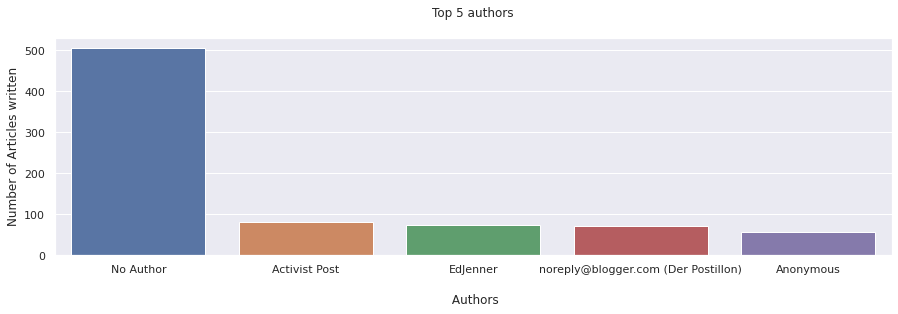

In [12]:
d = df['author'].value_counts().sort_values(ascending=False).head(5)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 5 authors

# Plotting
sns.set()
plt.figure(figsize=(15,4))
sns.barplot(x='index', y='author', data=d)
plt.xlabel("\n Authors")
plt.ylabel("Number of Articles written")
plt.title("Top 5 authors\n")
plt.show()

### Visualizing top 10 fake news site

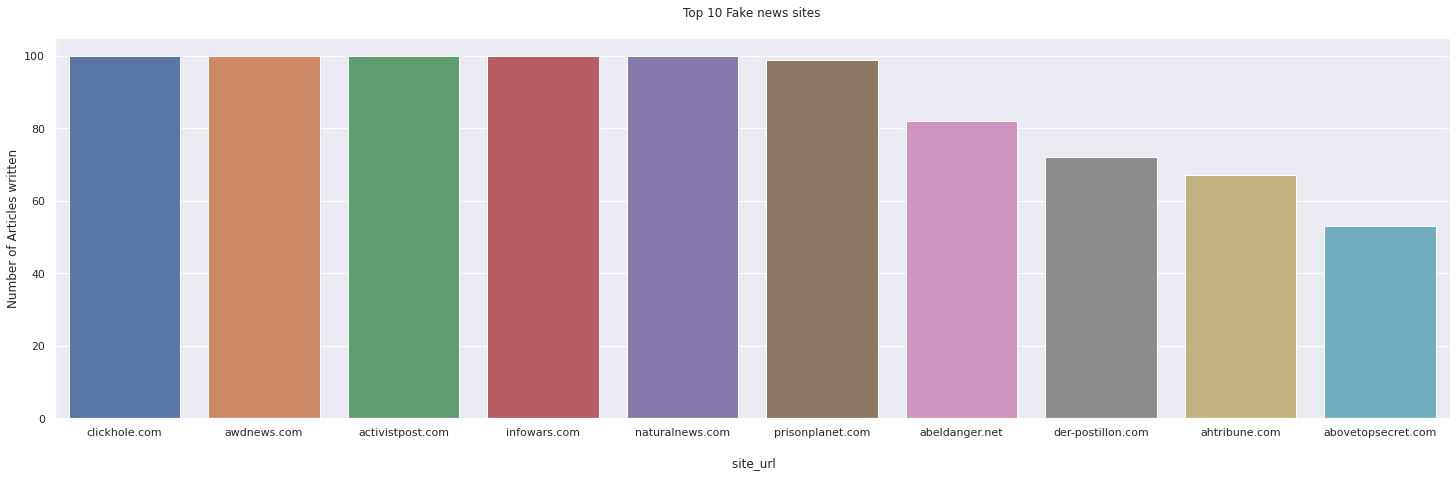

In [13]:
d = df[df['label'] == 'Fake']['site_url'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 10 fake news site

# Plotting
sns.set()
plt.figure(figsize=(25,7))
sns.barplot(x='index', y='site_url', data=d)
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Fake news sites\n")
plt.show()


### Let's have a look at the top 10 trustworthy news sites

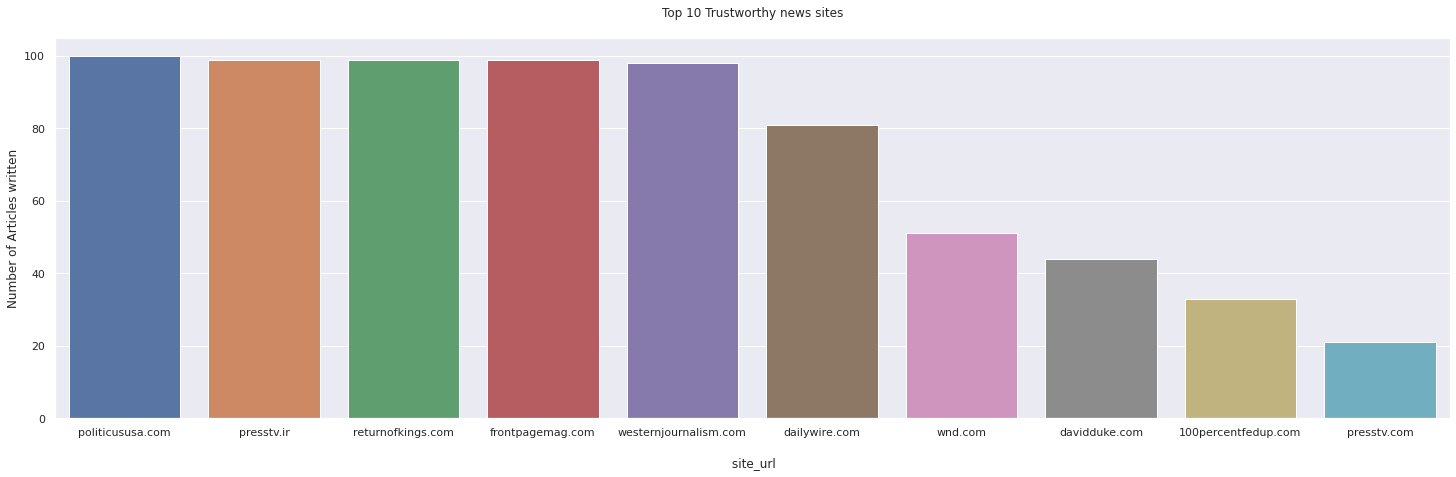

In [14]:
d = df[df['label'] == 'Real']['site_url'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 10 Trustworthy news site

# Plotting
sns.set()
plt.figure(figsize=(25,7))
sns.barplot(x='index', y='site_url', data=d)
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Trustworthy news sites\n")
plt.show()

In [15]:
#Let's reshuffle the dataset
df = df.sample(frac = 1)

#taking the features
features = df[['site_url', 'text_without_stopwords']]
features.head(5)

features['url_text'] = features["site_url"].astype(str) + " " + features["text_without_stopwords"]
features.drop(['site_url', 'text_without_stopwords'], axis = 1, inplace = True)

features.head()

,url_text
1555,presstv.ir iran raps rare eu clauses trade dea...
414,amren.com rancher yearns trump wall usmexico b...
759,dailywire.com tuesday night presidentelect don...
1210,infowars.com wikileaks email hillary campaign ...
33,21stcenturywire.com st century wire says wire ...


In [16]:
X = features
y = df['type']
y = y.tolist()

In [17]:
#Splitting the dataset and using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

tfidf_vectorizer = TfidfVectorizer(use_idf = True, stop_words = 'english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['url_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['url_text'])

In [18]:
tfidf_train = pd.DataFrame(X_train_tfidf.A, columns = tfidf_vectorizer.get_feature_names())

In [19]:
tfidf_train.head()

,100percentfedup,21stcenturywire,___,_url,aa,aab,aah,aand,aap,aaps,...,überrascht,überreden,überreicht,überschwänglich,überteuerten,übertrieben,überwachungskamera,überwältigt,überzeugt,übrig
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.226513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Above is the representation of tf-idf matrix

---
<p style="font-family: Arials; line-height: 1.3; font-size: 27px; font-weight: bold; letter-spacing: 2px; text-align: center; color: #23527c">Modelling</p>

In [20]:
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=5,random_state=1)
Adab.fit(tfidf_train, y_train)
y_pred3 = Adab.predict(X_test_tfidf)
ABscore = metrics.accuracy_score(y_test,y_pred3)
print("accuracy: %0.3f" %ABscore)

accuracy: 0.953


## **We got a testing accuracy of 0.959! Yay!**


<p style="font-family: Arials; line-height: 1.3; font-size: 20px; font-weight: bold; letter-spacing: 2px; text-align: left; color: #23527c">please upvote if you liked my notebook! :D</p>